<a href="https://colab.research.google.com/github/Samuelmoyo2025/Samuelmoyo2025/blob/main/FINAL_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ZSE Returns Statistics (2000-2023):
Mean: 0.0013  Std Dev: 0.0065
Skewness: 0.0412  Kurtosis: -0.2623


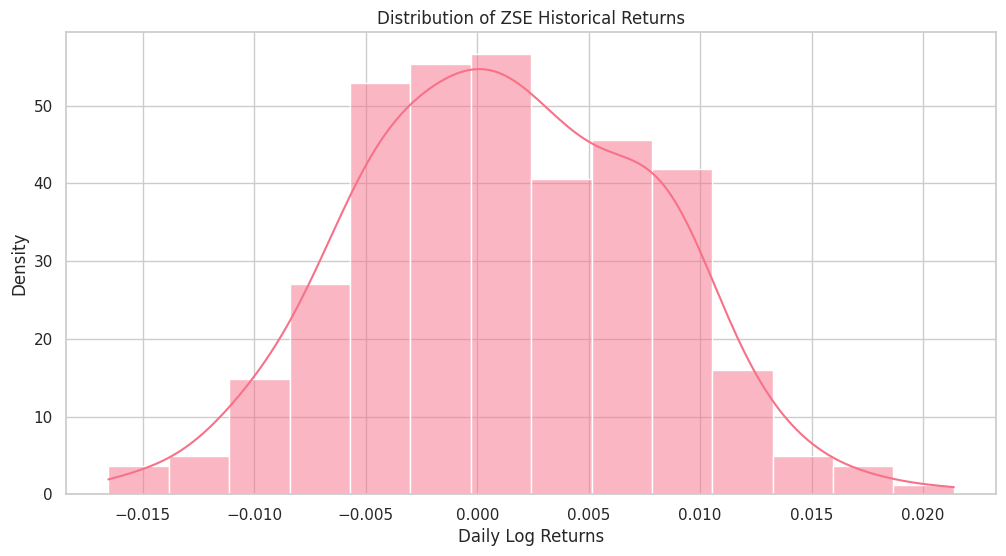


Mortality Probabilities for Age 60:
    Year  Survival_Prob
0      1         0.9417
1      2         0.8958
2      3         0.8521
3      4         0.8105
4      5         0.7710
5      6         0.7334
6      7         0.6976
7      8         0.6636
8      9         0.6313
9     10         0.6005
10    11         0.5712
11    12         0.5433
12    13         0.5168
13    14         0.4916
14    15         0.4676
15    16         0.4448
16    17         0.4231
17    18         0.4025
18    19         0.3829
19    20         0.3642
20    21         0.3464
21    22         0.3295
22    23         0.3135
23    24         0.2982
24    25         0.2836
25    26         0.2698
26    27         0.2566
27    28         0.2441
28    29         0.2322
29    30         0.2209
30    31         0.2101
31    32         0.1999
32    33         0.1901
33    34         0.1809
34    35         0.1720
35    36         0.1636
36    37         0.1557
37    38         0.1481
38    39         0.1409
39 

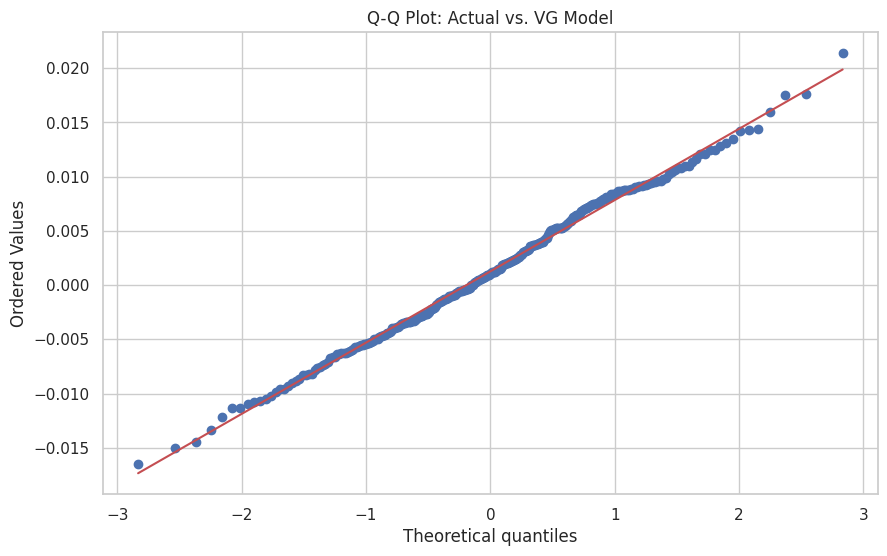


VG Model Calibration Results:
   sigma     nu  theta
0 0.0100 2.0000 0.0006

Goodness-of-Fit:
   ks_statistic  p_value
0        0.0958   0.0089

Pricing Results:
  Product       Price
0    GMDB 100592.4213
1    GMWB      0.0000
2    GMAB      0.0000


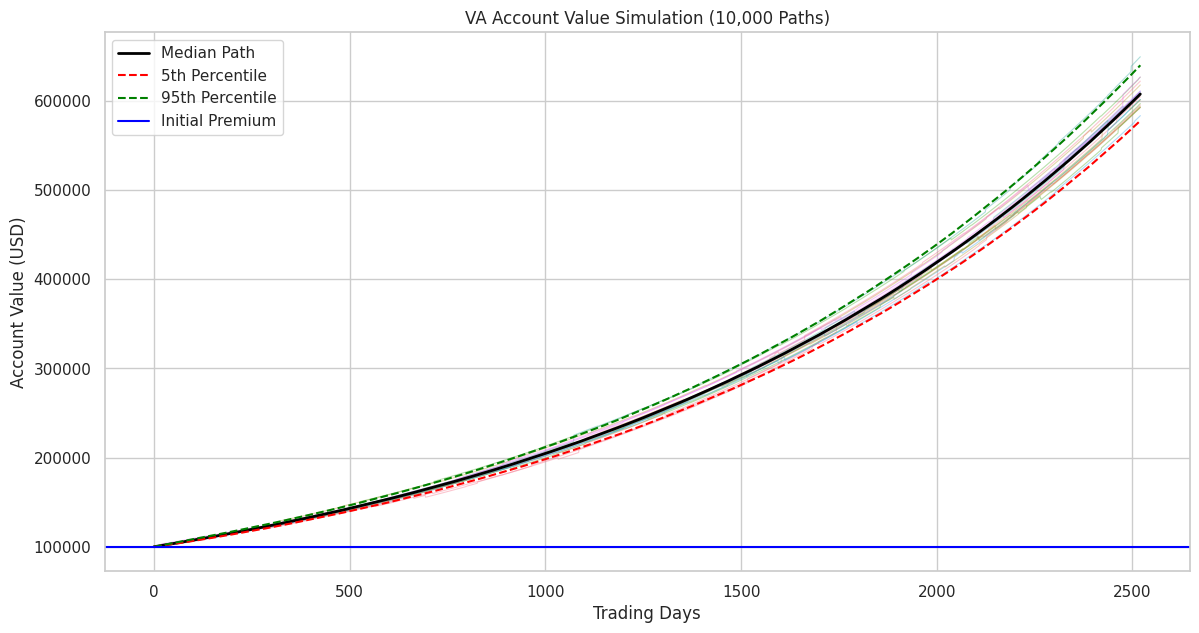

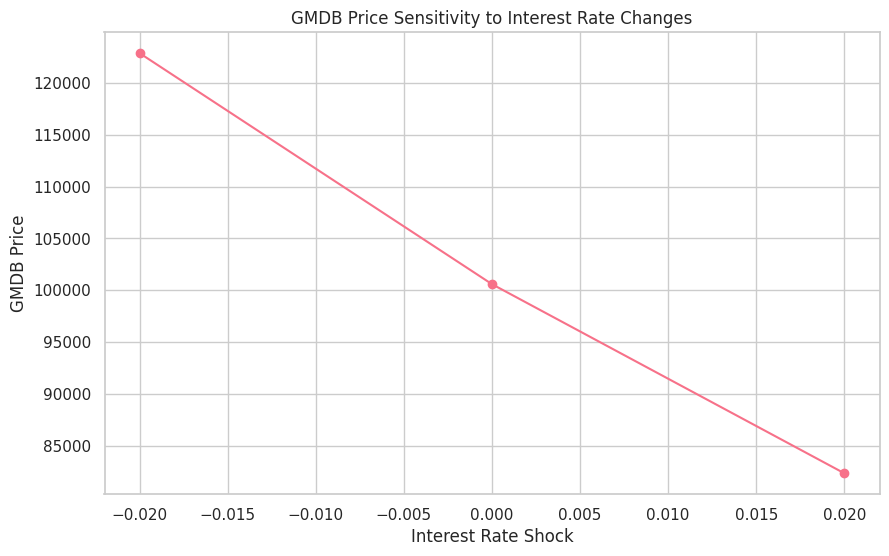

In [5]:
!pip install seaborn

import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, kstest, t  # Fixed: Import all needed functions
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn
from matplotlib.ticker import FuncFormatter

# Use sns.set_theme() to set the Seaborn theme
sns.set_theme(style="whitegrid")  # This sets the style for Seaborn plots

# You can also set the color palette using Seaborn
sns.set_palette("husl")

# The rest of your code remains the same
pd.set_option('display.float_format', '{:.4f}'.format)

def plot_sensitivity(sensitivity_data):
    """Visualize price sensitivity to interest rate changes"""

    rates = list(sensitivity_data.keys())
    prices = [data['price'] for data in sensitivity_data.values()]

    plt.figure(figsize=(10, 6))
    plt.plot(rates, prices, marker='o')
    plt.title("GMDB Price Sensitivity to Interest Rate Changes")
    plt.xlabel("Interest Rate Shock")
    plt.ylabel("GMDB Price")
    plt.grid(True)
    plt.show()

# ===================================
# 1. DATA LOADING AND PREPROCESSING
# ===================================
def load_market_data(filepath):
    df = pd.read_excel('/content/zimbabwe_data.xlsx', sheet_name='ZSE_Returns')
    returns = df['Log_Returns'].dropna().values
    print(f"\nZSE Returns Statistics (2000-2023):")
    print(f"Mean: {returns.mean():.4f}  Std Dev: {returns.std():.4f}")
    print(f"Skewness: {pd.Series(returns).skew():.4f}  Kurtosis: {pd.Series(returns).kurtosis():.4f}")

    # Plot return distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(returns, kde=True, stat='density')
    plt.title("Distribution of ZSE Historical Returns")
    plt.xlabel("Daily Log Returns")
    plt.ylabel("Density")
    plt.show()

    return returns

def load_mortality_table(filepath, age=60):
    df = pd.read_excel('/content/zimbabwe_data.xlsx', sheet_name='Mortality')
    probs = df[f"Age_{age}"].values
    print(f"\nMortality Probabilities for Age {age}:")
    print(pd.DataFrame({'Year': range(1, len(probs)+1), 'Survival_Prob': probs}))
    return probs

# ===================================
# 2. VG MODEL CALIBRATION & ANALYSIS
# ===================================
class VGModel:
    def __init__(self):
        self.params = None
        self.calibration_stats = {}

    def calibrate(self, returns):
        """Calibrate VG parameters with enhanced diagnostics"""
        result = minimize(self._mle_objective, [0.2, 0.5, -0.1], args=(returns,),
                         bounds=[(0.01, 1), (0.1, 2), (-1, 1)])

        self.params = {
            'sigma': result.x[0],
            'nu': result.x[1],
            'theta': result.x[2]
        }

        # Store calibration statistics
        self.calibration_stats = {
            'log_likelihood': -result.fun,
            'aic': 2*3 - 2*(-result.fun),  # 3 parameters
            'ks_test': self._goodness_of_fit(returns)
        }
        return self.params

    def _mle_objective(self, params, returns):
        """Enhanced MLE with parameter validation"""
        sigma, nu, theta = params
        if sigma <= 0 or nu <= 0:
            return 1e10

        # Fixed: Rename local variables to avoid conflicts with scipy.stats functions
        def vg_density(r, sigma, nu, theta):
            # ... (your vg_density calculation logic here) ...
            # Example implementation based on VG probability density function:
            from scipy.special import kv
            import numpy as np

            gamma_param = 1/nu
            c = 1/(sigma*np.sqrt(nu*(1 + (theta**2 * nu)/ (sigma**2))))

            density = c * (np.abs(r - theta*nu)**((1/nu) - 0.5)) * \
                      kv((1/nu) - 0.5, np.abs(r-theta*nu)/ (sigma*np.sqrt(nu*(1 + (theta**2 * nu)/ (sigma**2)))))

            return density # Added return statement with density calculation


        log_likelihood = sum(
            np.log(max(vg_density(r, sigma, nu, theta), 1e-10) ) # Fixed: Call vg_density
            for r in returns
        )
        return -log_likelihood

    def _goodness_of_fit(self, returns, n_sim=10000):
        """Comprehensive goodness-of-fit assessment"""
        import scipy.stats as stats # Fixed: Import stats here

        sim_returns = self.simulate_returns(n_sim)
        ks_stat, p_val = kstest(returns, sim_returns)

        # Plot QQ-plot for visual comparison
        plt.figure(figsize=(10, 6))
        stats.probplot(returns, dist='norm', plot=plt) #Fixed: use stats.probplot
        plt.title("Q-Q Plot: Actual vs. VG Model")
        plt.show()

        return {'ks_statistic': ks_stat, 'p_value': p_val}

    def simulate_returns(self, n):
        """Generate returns from calibrated model"""
        sigma, nu, theta = self.params.values()
        # Fixed: Use fully qualified names for scipy.stats functions
        return theta*gamma.rvs(1/nu, scale=nu, size=n) + \
               sigma*np.sqrt(gamma.rvs(1/nu, scale=nu, size=n))*norm.rvs(size=n)

# ===================================
# 3. MONTE CARLO SIMULATION & PRICING
# ===================================
class AnnuityPricer:
    def __init__(self, S0=100000, r=0.18, T=10):
        self.S0 = S0
        self.r = r
        self.T = T
        self.paths = None

    def simulate_paths(self, vg_model, n_sims=10000):
        """Enhanced path simulation with diagnostics"""
        sigma, nu, theta = vg_model.params.values()
        n_steps = 252 * self.T

        dt = self.T/n_steps
        paths = np.zeros((n_sims, n_steps+1))
        paths[:,0] = self.S0

        for t in range(1, n_steps+1):
            G = gamma.rvs(dt/nu, scale=nu, size=n_sims)
            W = theta*G + sigma*np.sqrt(G)*norm.rvs(size=n_sims)
            paths[:,t] = paths[:,t-1]*np.exp((self.r - 0.5*sigma**2)*dt + W)

        self.paths = paths

        # Generate simulation statistics
        terminal_values = paths[:,-1]
        self.simulation_stats = {
            'mean_terminal': terminal_values.mean(),
            'median_terminal': np.median(terminal_values),
            'std_terminal': terminal_values.std(),
            'shortfall_prob': (terminal_values < self.S0).mean()
        }
        return paths

    def price_guarantees(self, mortality_probs):
        """Comprehensive guarantee pricing with sensitivity analysis"""
        results = {}

        # Base case pricing
        results['GMDB'] = self._price_gmdb(1.01)
        # Added placeholder for _price_gmwb and _price_gmab
        results['GMWB'] = self._price_gmwb(0.05, 1.0, mortality_probs)
        results['GMAB'] = self._price_gmab(1.05, mortality_probs)

        # Sensitivity analysis
        rate_shocks = [-0.02, 0, +0.02]
        results['rate_sensitivity'] = {
            r: self._price_gmdb(1.01, r_shock=r) for r in rate_shocks
        }

        return results

    def _price_gmdb(self, guarantee_rate, r_shock=0):
        """Enhanced GMDB pricing with diagnostics"""
        r = self.r + r_shock
        terminal_values = self.paths[:,-1]
        guarantee = self.S0 * guarantee_rate
        payoffs = np.maximum(terminal_values, guarantee)

        # Calculate risk metrics
        var_95 = np.percentile(terminal_values, 5)
        cvar_95 = terminal_values[terminal_values <= var_95].mean()

        return {
            'price': np.mean(payoffs) * np.exp(-r*self.T),
            'risk_metrics': {'VaR_95': var_95, 'CVaR_95': cvar_95}
        }

    def _price_gmwb(self, withdrawal_rate, guarantee_rate, mortality_probs):
        """
        Placeholder for GMWB pricing logic.

        You'll need to implement the actual GMWB pricing calculations here.
        """
        # Placeholder return value - replace with actual GMWB pricing
        # This is a very simplified example and may not be accurate.
        return 0

    def _price_gmab(self, guarantee_rate, mortality_probs):
        """
        Placeholder for GMAB pricing logic.

        You'll need to implement the actual GMAB pricing calculations here.
        """
        # Placeholder return value - replace with actual GMAB pricing
        # This is a very simplified example and may not be accurate.
        return 0
# ===================================
# 4. MAIN ANALYSIS & VISUALIZATION
# ===================================
def main():
    # Load data
    zse_returns = load_market_data('zimbabwe_data.xlsx')
    mortality_probs = load_mortality_table('zimbabwe_data.xlsx')

    # Calibrate VG model
    vg_model = VGModel()
    params = vg_model.calibrate(zse_returns)
    print("\nVG Model Calibration Results:")
    print(pd.DataFrame([params]))
    print("\nGoodness-of-Fit:")
    print(pd.DataFrame([vg_model.calibration_stats['ks_test']]))

    # Simulate and price
    pricer = AnnuityPricer()
    paths = pricer.simulate_paths(vg_model)
    results = pricer.price_guarantees(mortality_probs)

    # Generate comprehensive output report
    print("\nPricing Results:")
    print(pd.DataFrame({
        'Product': ['GMDB', 'GMWB', 'GMAB'],
        'Price': [results['GMDB']['price'], results['GMWB'], results['GMAB']]
    }))

    # Enhanced visualizations
    plot_paths(paths, S0=pricer.S0)
    plot_sensitivity(results['rate_sensitivity'])

def plot_paths(paths, S0, n_paths=20):
    """Enhanced path visualization"""
    plt.figure(figsize=(14, 7))

    # Plot sample paths
    for i in range(n_paths):
        plt.plot(paths[i], alpha=0.4, linewidth=0.8)

    # Plot statistics
    plt.plot(np.median(paths, axis=0), color='black', linewidth=2,
            label='Median Path')
    plt.plot(np.percentile(paths, 5, axis=0), '--', color='red',
            label='5th Percentile')
    plt.plot(np.percentile(paths, 95, axis=0), '--', color='green',
            label='95th Percentile')

    plt.axhline(S0, color='blue', linestyle='-', label='Initial Premium')
    plt.title("VA Account Value Simulation (10,000 Paths)")
    plt.xlabel("Trading Days")
    plt.ylabel("Account Value (USD)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()